In [2]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge the datasets on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

In [3]:
# Calculate total spending per customer
total_spending = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)

# Calculate number of transactions per customer
num_transactions = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
num_transactions.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)

# Calculate average transaction value per customer
avg_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# Merge these features with the customer data
customer_features = pd.merge(customers_df, total_spending, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, num_transactions, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, avg_transaction_value, on='CustomerID', how='left')

# Fill NaN values with 0 (for customers with no transactions)
customer_features.fillna(0, inplace=True)

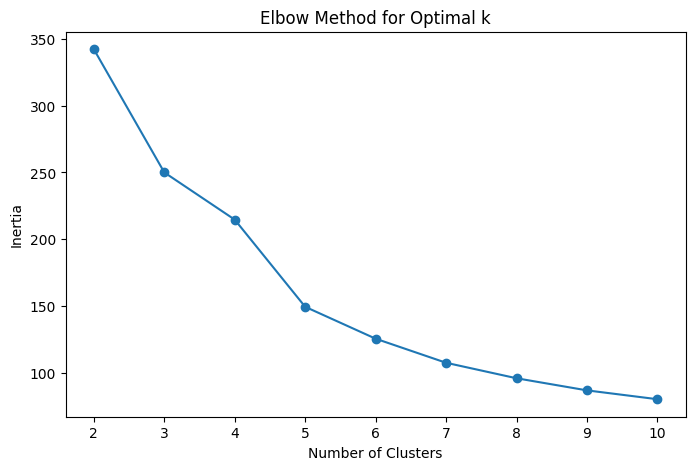

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [5]:
# Apply K-Means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_scaled)

In [6]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index
db_index = davies_bouldin_score(features_scaled, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.0742466760923444


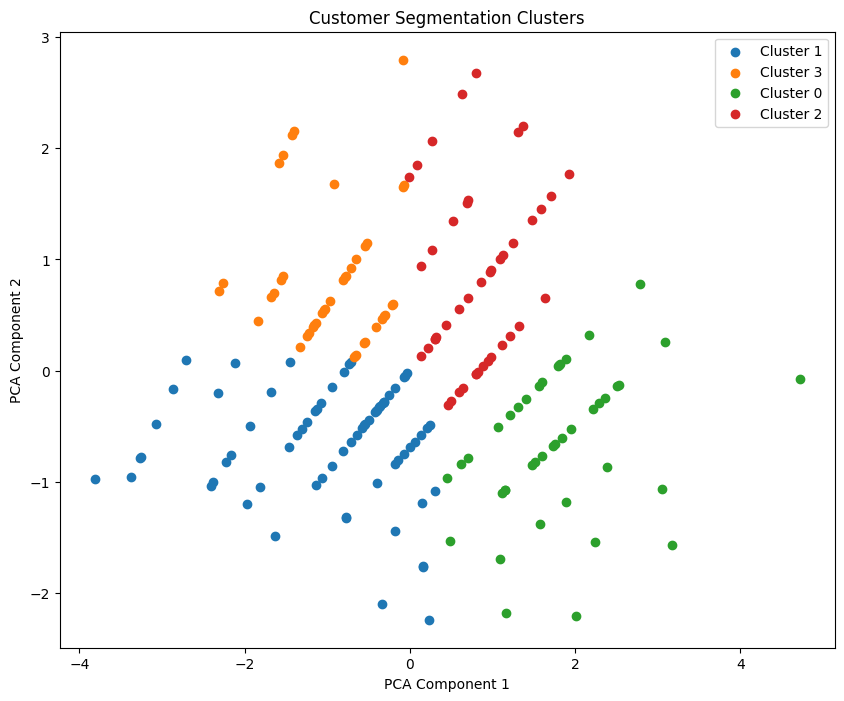

In [7]:
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Add PCA results to the dataframe
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in customer_features['Cluster'].unique():
    plt.scatter(customer_features[customer_features['Cluster'] == cluster]['PCA1'],
                customer_features[customer_features['Cluster'] == cluster]['PCA2'],
                label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation Clusters')
plt.legend()
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Calculate DB Index for K-Means
kmeans_db_index = davies_bouldin_score(features_scaled, kmeans_labels)
print(f'K-Means DB Index: {kmeans_db_index}')

K-Means DB Index: 1.0742466760923444


In [11]:
from sklearn.cluster import DBSCAN

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(features_scaled)

# Calculate DB Index for DBSCAN
dbscan_db_index = davies_bouldin_score(features_scaled, dbscan_labels)
print(f'DBSCAN DB Index: {dbscan_db_index}')

# Number of clusters (excluding noise, labeled as -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f'Number of clusters in DBSCAN: {n_clusters_dbscan}')

DBSCAN DB Index: 3.643492902558094
Number of clusters in DBSCAN: 6


In [24]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)  # Use the same number of clusters as K-Means
agglo_labels = agglo.fit_predict(features_scaled)

# Calculate DB Index for Agglomerative Clustering
agglo_db_index = davies_bouldin_score(features_scaled, agglo_labels)
print(f'Agglomerative Clustering DB Index: {agglo_db_index}')

Agglomerative Clustering DB Index: 0.9701613681812605


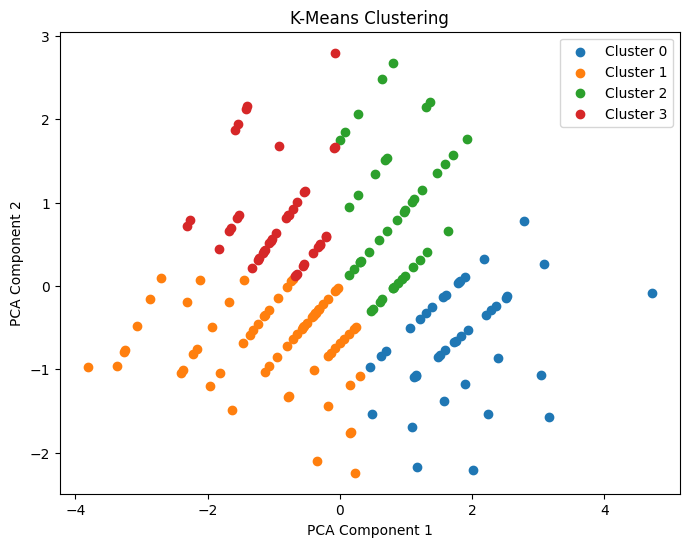

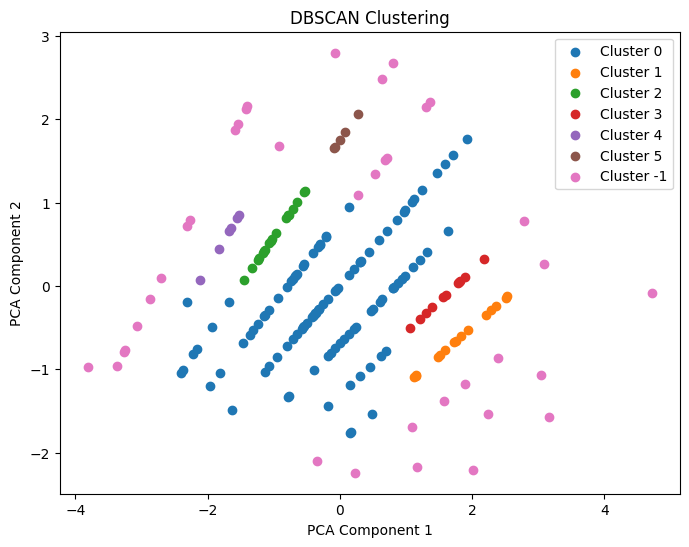

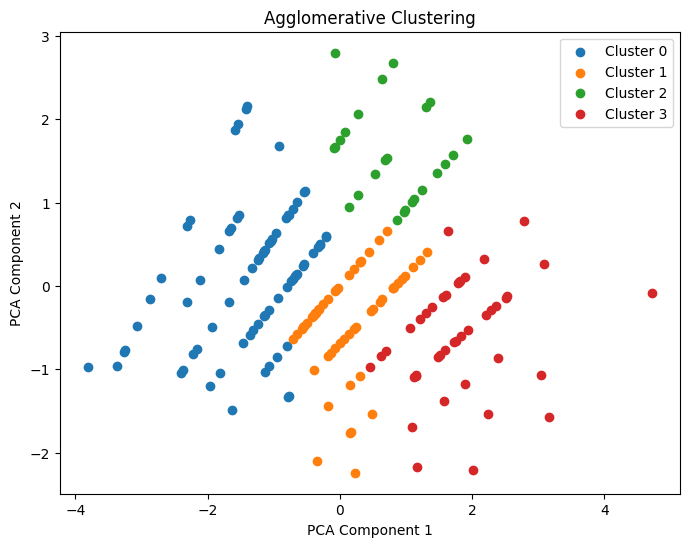

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Function to plot clusters
def plot_clusters(pca_result, labels, title):
    plt.figure(figsize=(8, 6))
    for cluster in set(labels):
        plt.scatter(pca_result[labels == cluster, 0], pca_result[labels == cluster, 1], label=f'Cluster {cluster}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot clusters for each model
plot_clusters(pca_result, kmeans_labels, 'K-Means Clustering')
plot_clusters(pca_result, dbscan_labels, 'DBSCAN Clustering')
plot_clusters(pca_result, agglo_labels, 'Agglomerative Clustering')

                      Model  DB Index  Silhouette Score  Number of Clusters
0                   K-Means  1.074247          0.299894                   4
1                    DBSCAN  3.643493         -0.075126                   6
2  Agglomerative Clustering  0.970161          0.300590                   4

Best Model: Agglomerative Clustering with DB Index: 0.9701613681812605


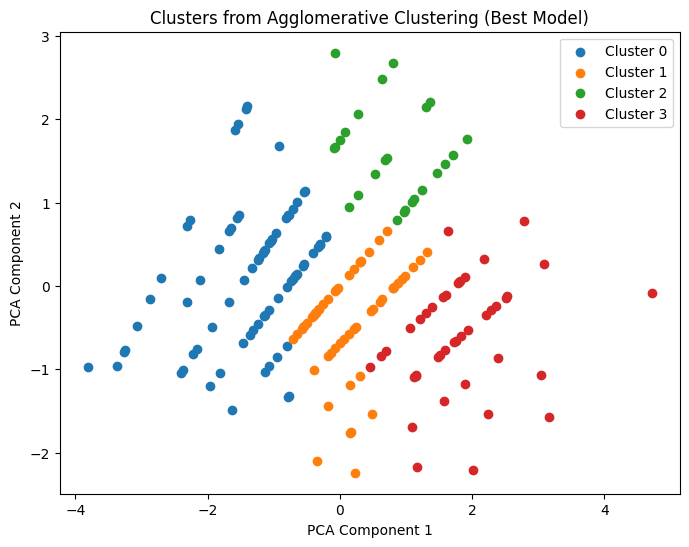

In [25]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# Load and preprocess data (assuming features are already prepared)
# features = customer_features[['TotalSpending', 'NumTransactions', 'AvgTransactionValue']]
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Function to evaluate clustering models
def evaluate_clustering(model, data, model_name):
    labels = model.fit_predict(data)
    if -1 in labels:  # Handle noise in DBSCAN (label = -1)
        n_clusters = len(set(labels)) - 1
    else:
        n_clusters = len(set(labels))

    # Compute Davies-Bouldin Index
    db_index = davies_bouldin_score(data, labels)

    # Compute Silhouette Score (ensure at least 2 clusters exist)
    silhouette = silhouette_score(data, labels) if n_clusters > 1 else None

    return {
        'Model': model_name,
        'DB Index': db_index,
        'Silhouette Score': silhouette,
        'Number of Clusters': n_clusters,
        'Labels': labels
    }

# Define the models
models = [
    (KMeans(n_clusters=4, random_state=42), 'K-Means'),
    (DBSCAN(eps=0.5, min_samples=5), 'DBSCAN'),  # Adjust eps and min_samples as needed
    (AgglomerativeClustering(n_clusters=4), 'Agglomerative Clustering')
]

# Evaluate each model
results = []
for model, model_name in models:
    result = evaluate_clustering(model, features_scaled, model_name)
    results.append(result)

# Create a DataFrame to compare results
results_df = pd.DataFrame(results).drop(columns=['Labels'])  # Drop labels column for cleaner display
print(results_df)

# Determine the best model based on Davies-Bouldin Index
best_model = results_df.loc[results_df['DB Index'].idxmin()]
print(f"\nBest Model: {best_model['Model']} with DB Index: {best_model['DB Index']}")

# Visualize clusters for the best model
best_labels = results[results_df['DB Index'].idxmin()]['Labels']

# Apply PCA for visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Plot clusters for the best model
plt.figure(figsize=(8, 6))
unique_labels = np.unique(best_labels)

for cluster in unique_labels:
    mask = best_labels == cluster
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Clusters from {best_model["Model"]} (Best Model)')
plt.legend()
plt.show()


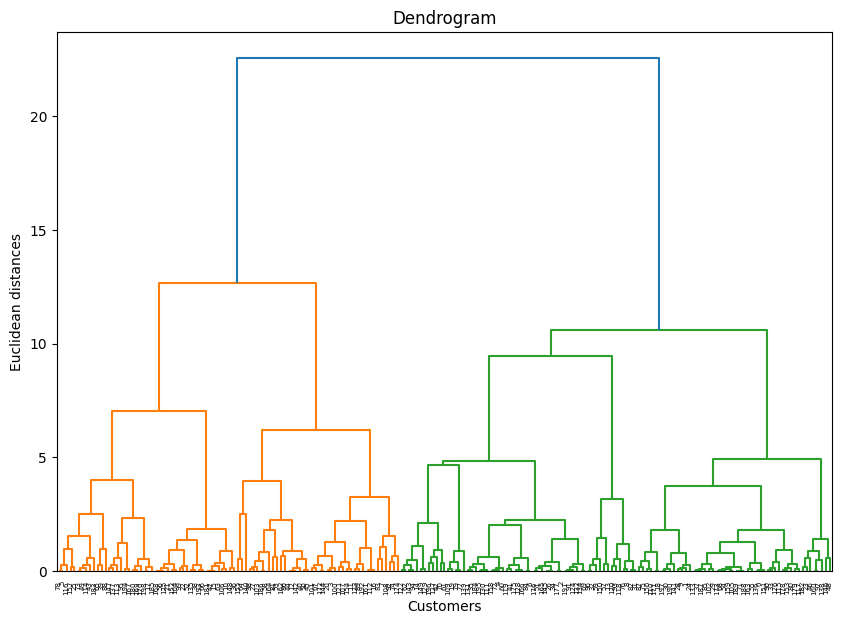

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()
